# Time series model to predict PM 2.5 readings (Air Quality) in Dar es Salaam 

# Install needed libraries

In [ ]:
!pip install statsmodels

In [ ]:
!pip install seaborn

In [2]:
!pip install plotly

     |████████████████████████████████| 15.2 MB 2.6 MB/s eta 0:00:01


In [ ]:
!pip install matplotlib

In [3]:
#import needed libraries
import time
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pytz
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import warnings

In [4]:
#set notebook to igore future warning from python
warnings.simplefilter(action="ignore", category=FutureWarning)

## Data ingestion and preparation 

In [6]:
filepath = "data/air_quality_raw.csv"

In [7]:
df = pd.read_csv(filepath)

In [8]:
df.head()

,Unnamed: 0,timestamp,P2
0,1,2018-01-01 00:00:56.670,7.77
1,2,2018-01-01 00:03:25.965,10.00
2,3,2018-01-01 00:05:55.139,10.53
3,4,2018-01-01 00:08:24.675,11.30
4,5,2018-01-01 00:10:53.974,9.77


In [9]:
df.columns

Index(['Unnamed: 0', 'timestamp', 'P2'], dtype='object')

In [10]:
# unamed column
df.drop(columns = 'Unnamed: 0', inplace=True)

In [11]:
print(df.shape)
df.head()

(51923, 2)


,timestamp,P2
0,2018-01-01 00:00:56.670,7.77
1,2018-01-01 00:03:25.965,10.00
2,2018-01-01 00:05:55.139,10.53
3,2018-01-01 00:08:24.675,11.30
4,2018-01-01 00:10:53.974,9.77


In [21]:
#data wrangle fxn ---run for new data only ----
def wrangle(filepath):
    df = pd.read_csv(filepath, index_col="timestamp")
    #set index to datetime value value type and covert timezone
    df.index = pd.to_datetime(df.index)
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")
    #remove outliers (remove readings greater than 100)
    df = df[df["P2"]<100]
    #resample the data to hourly readers (1H), then fill forward for empty readings
    y = df["P2"].resample("1H").mean().fillna(method="ffill")
    
    return y



## Prepare wrangle fxn

In [12]:
#set index to datetime value value type and covert timezone
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")

In [13]:
df.head()

,timestamp,P2
1970-01-01 03:00:00+03:00,2018-01-01 00:00:56.670,7.77
1970-01-01 03:00:00.000000001+03:00,2018-01-01 00:03:25.965,10.00
1970-01-01 03:00:00.000000002+03:00,2018-01-01 00:05:55.139,10.53
1970-01-01 03:00:00.000000003+03:00,2018-01-01 00:08:24.675,11.30
1970-01-01 03:00:00.000000004+03:00,2018-01-01 00:10:53.974,9.77


<AxesSubplot:>

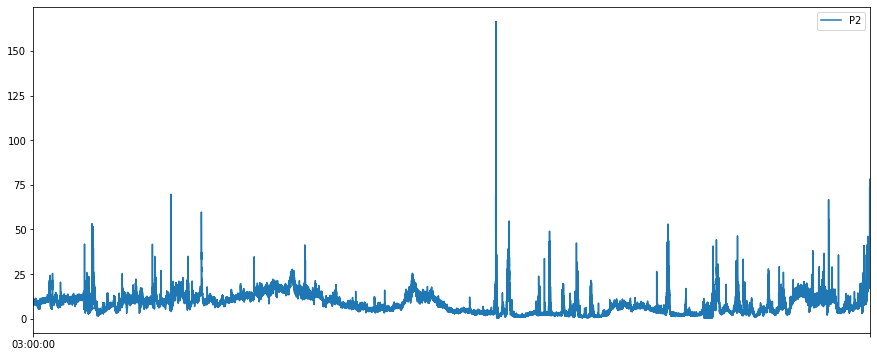

In [15]:
#Visiualize the data
fig, ax = plt.subplots(figsize = (15,6))
df.plot(ax = ax)

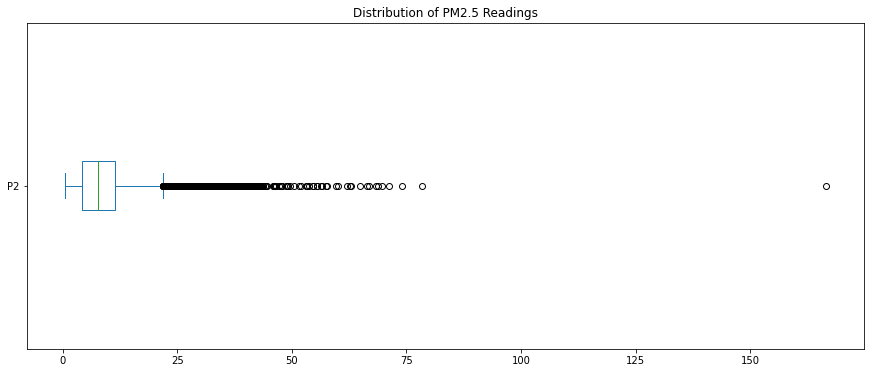

In [16]:
#check for outliers using a boxplot
fig, ax = plt.subplots(figsize=(15, 6))
df.plot(
    kind = "box",
    vert = False,
    title = "Distribution of PM2.5 Readings",
    ax = ax
);

PM 2 readings generally reads from 1 - 500, however we will treat readings above 100 as outlier

In [17]:
df = df[df["P2"] < 100]
df.shape

(51922, 2)

In [18]:
len(df)

51922

## Run the Wrangle function

In [22]:
y = wrangle(filepath)

In [23]:
print(y.shape)
y.head()

(1704,)


timestamp
2018-01-01 03:00:00+03:00    9.456327
2018-01-01 04:00:00+03:00    9.400833
2018-01-01 05:00:00+03:00    9.331458
2018-01-01 06:00:00+03:00    9.528776
2018-01-01 07:00:00+03:00    8.861250
Freq: H, Name: P2, dtype: float64

In [24]:
df = pd.DataFrame(y)
print(df.shape)
df.head()

(1704, 1)


,P2
timestamp,
2018-01-01 03:00:00+03:00,9.456327
2018-01-01 04:00:00+03:00,9.400833
2018-01-01 05:00:00+03:00,9.331458
2018-01-01 06:00:00+03:00,9.528776
2018-01-01 07:00:00+03:00,8.861250


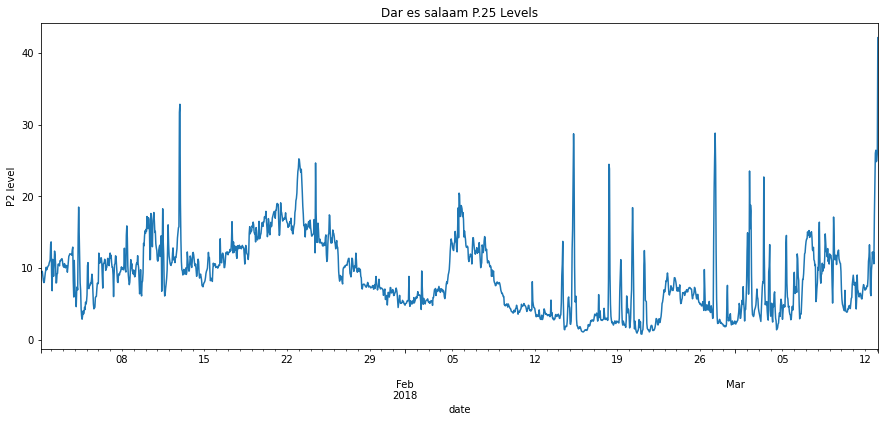

In [25]:
fig, ax = plt.subplots(figsize = (15,6))
df["P2"].plot(ax = ax, xlabel="date", ylabel ="P2 level", title="Dar es salaam P.25 Levels");

Plot the rolling average of the readings in y. Use a window size of 168 (the number of hours in a week)

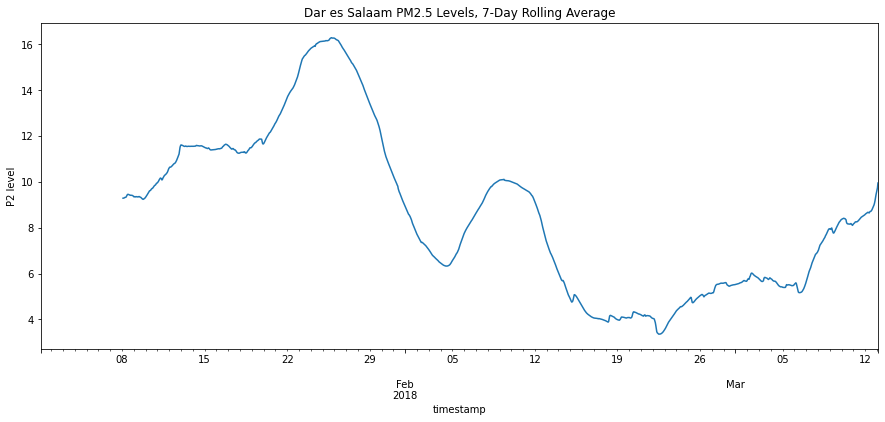

In [26]:
fig, ax  = plt.subplots(figsize = (15, 6))
df["P2"].rolling(168).mean().plot(ax=ax, label="date", 
                                  ylabel ="P2 level", 
                                  title="Dar es Salaam PM2.5 Levels, 7-Day Rolling Average"
                                 );

ACF and PACF plots tells us how many lags we can have in our model and still have a good predictive model, it tests for correction, for small data we can do y.corr(y.shift(number_of_lags) to test for correlation, but pcf makes a visualization of it.PACF plt gives us the actual lag we can use for the prediction, ACF just gives idea of how our data is correlated

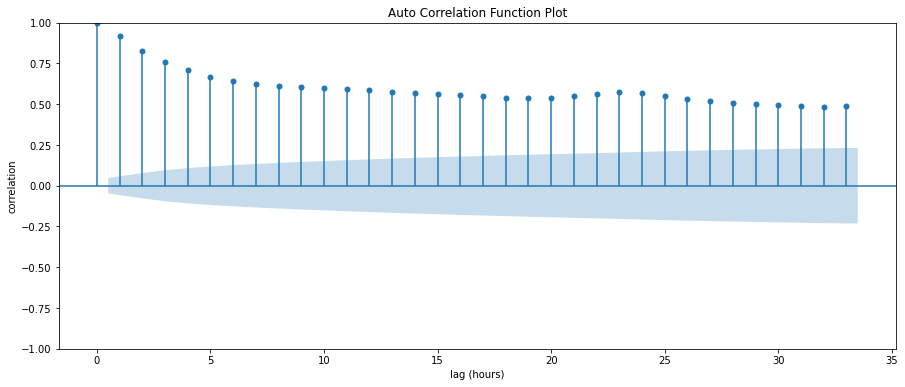

In [27]:
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(y, ax=ax);
plt.xlabel("lag (hours)"),
plt.ylabel("correlation"),
plt.title("Auto Correlation Function Plot");

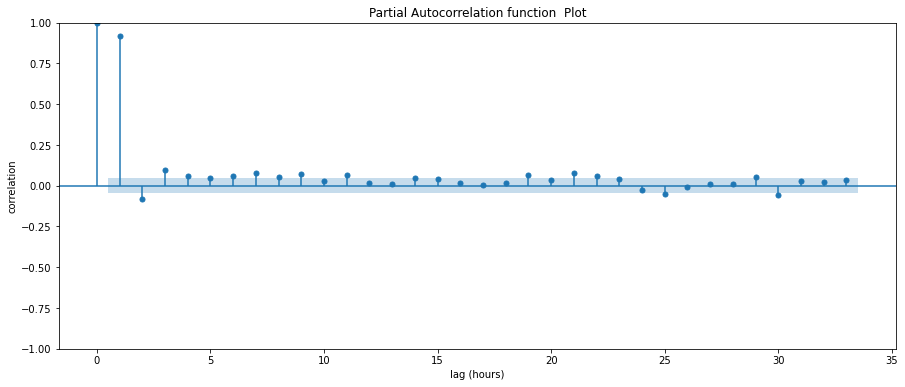

In [28]:
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(y, ax=ax);
plt.xlabel("lag (hours)"),
plt.ylabel("correlation"),
plt.title("Partial Autocorrelation function  Plot");


we can do a have a meaningful lag upto 30 hours as it shows some correlation

# Split

Split y into training and test sets. The first 90% of the data should be in your training set. The remaining 10% should be in the test set. note because this is a time series data, won't use train-test split, rather we will cutoff into 2

In [29]:
cutoff = int(len(y)*0.9)
y_train = y.iloc[:cutoff]
y_test = y.iloc[cutoff:]

print("y_train shape: ", y_train.shape)
print("y_test shape; ", y_test.shape)

y_train shape:  (1533,)
y_test shape;  (171,)


# Build model

## Baseline mae

In [30]:
y_train_mean  = round(y_train.mean(),2)
#get a column (the length of y_train) with mean as the predicted value. [y_train_mean] is the absolute value of the mean
y_baseline = [y_train_mean]*len(y_train) 
#baseline mae
baseline_mae = round(mean_absolute_error(y_train, y_baseline), 2)
print("y_train_mean: ", y_train_mean)
print("baseline mean absolute error: ", baseline_mae)

y_train_mean:  8.62
baseline mean absolute error:  4.08


## Iterate

do a parameter search for the best lag (p) with the lowest MAE, given that from the PACF plot we got reasonable relationship upto 30 hours, so we set our parameter range from 1 to 31

In [31]:
p_params = range(1,31)
maes = []
for p in p_params:
    #note start time
    start_time = time.time()
    #train the model
    model = AutoReg(y_train, lags = p).fit()
    #check elapse time
    elapse_time = round(time.time() - start_time,2)
    print(f"Trained AutoReg {p} in {elapse_time} seconds")
    #generate in-sample (training ) predictions
    y_pred = model.predict().dropna()
    #calculate training mae
    mae = mean_absolute_error(y_train[p:], y_pred)
    #Append MAe to list
    maes.append(mae)
#mae series 
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()
          
    


Trained AutoReg 1 in 0.01 seconds
Trained AutoReg 2 in 0.01 seconds
Trained AutoReg 3 in 0.0 seconds
Trained AutoReg 4 in 0.01 seconds
Trained AutoReg 5 in 0.01 seconds
Trained AutoReg 6 in 0.0 seconds
Trained AutoReg 7 in 0.01 seconds
Trained AutoReg 8 in 0.01 seconds
Trained AutoReg 9 in 0.01 seconds
Trained AutoReg 10 in 0.01 seconds
Trained AutoReg 11 in 0.01 seconds
Trained AutoReg 12 in 0.01 seconds
Trained AutoReg 13 in 0.01 seconds
Trained AutoReg 14 in 0.01 seconds
Trained AutoReg 15 in 0.01 seconds
Trained AutoReg 16 in 0.01 seconds
Trained AutoReg 17 in 0.01 seconds
Trained AutoReg 18 in 0.01 seconds
Trained AutoReg 19 in 0.01 seconds
Trained AutoReg 20 in 0.01 seconds
Trained AutoReg 21 in 0.01 seconds
Trained AutoReg 22 in 0.01 seconds
Trained AutoReg 23 in 0.02 seconds
Trained AutoReg 24 in 0.02 seconds
Trained AutoReg 25 in 0.02 seconds
Trained AutoReg 26 in 0.02 seconds
Trained AutoReg 27 in 0.01 seconds
Trained AutoReg 28 in 0.02 seconds
Trained AutoReg 29 in 0.01 seco

1    0.947888
2    0.933894
3    0.920850
4    0.920153
5    0.919519
Name: mae, dtype: float64

In [32]:
mae_series.sort_values(ascending=True).head()

28    0.906776
27    0.907315
26    0.907333
25    0.907563
29    0.908026
Name: mae, dtype: float64

In [33]:
#lag (p) 28 gave us the best MAE of 0.906776, so we set our best-p to 28
best_p = 28
best_model = AutoReg(y_train, lags=best_p).fit()


In [34]:
best_model.forecast()

2018-03-06 00:00:00+03:00    8.056391
Freq: H, dtype: float64

In [35]:
y_test.head()

timestamp
2018-03-06 00:00:00+03:00    9.393056
2018-03-06 01:00:00+03:00    7.227561
2018-03-06 02:00:00+03:00    6.438140
2018-03-06 03:00:00+03:00    7.306190
2018-03-06 04:00:00+03:00    7.385122
Freq: H, Name: P2, dtype: float64

# Model Evaluation

to visualize the model performance we will use walk_forward_validation;
remember y = y_train + y_test (when we cutoff above) we will make a copy of the y_train as history, then we will forcast each next time (index) that follows individually the length of y_test, appending the forcast to a series we call y_pred_wfv 

In [36]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=best_p).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

timestamp
2018-03-06 00:00:00+03:00    8.056391
2018-03-06 01:00:00+03:00    8.681779
2018-03-06 02:00:00+03:00    6.268951
2018-03-06 03:00:00+03:00    6.303760
2018-03-06 04:00:00+03:00    7.171444
Freq: H, Name: prediction, dtype: float64

# Communicate Results

create a dataframe from the y_test and y_pred_wfv series by putting them in a dictionary and plot to visualize the performance of the model

In [37]:
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred_wfv": y_pred_wfv
        
    }, index=y_test.index
)
df_pred_test.head()

,y_test,y_pred_wfv
timestamp,,
2018-03-06 00:00:00+03:00,9.393056,8.056391
2018-03-06 01:00:00+03:00,7.227561,8.681779
2018-03-06 02:00:00+03:00,6.438140,6.268951
2018-03-06 03:00:00+03:00,7.306190,6.303760
2018-03-06 04:00:00+03:00,7.385122,7.171444


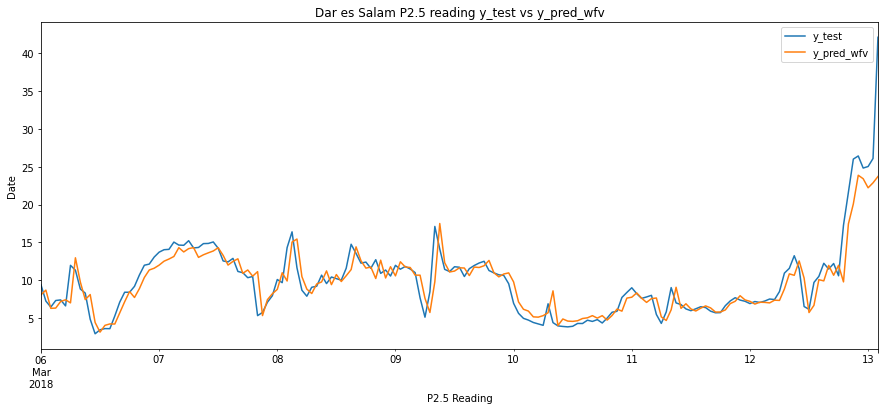

In [47]:
fig, ax = plt.subplots(figsize=(15,6))
df_pred_test.plot(kind="line", ax = ax,
                 title="Dar es Salam P2.5 reading y_test vs y_pred_wfv",
                 xlabel="P2.5 Reading",
                 ylabel="Date");